#Email SPAM/HAM Classification 

#Download dataset from Kaggle 
- Data: https://www.kaggle.com/venky73/spam-mails-dataset
- Reference: https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [ ]:
#Install the Kaggle library
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
#Allocate the required permission for this file
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
#Download
!kaggle datasets download venky73/spam-mails-dataset

spam-mails-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip spam-mails-dataset.zip

Archive:  spam-mails-dataset.zip
replace spam_ham_dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: spam_ham_dataset.csv    


- Try: Downloading Gmail mbox dataset

#Steps:
- Step 1: Understand the data
- Step 2: Preprocessing
  - Stop-Word Removal
  - Lower Casing
  - Stemming
  - Lemmatization
  - Tokenization
- Step 3: BAG OF WORDS
- Step 4: TF-IDF
- Step 5: Train Model
- Step 6: Evaluation

#Imports

In [ ]:
#Basic
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import re

#Text processing
import nltk as nl
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 

#Feature extraction and data preparation for model
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split

#Model
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neural_network import MLPClassifier

#Evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score


In [ ]:
#Download resources from nltk
nl.download('wordnet')
nl.download('omw-1.4')
nl.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

#Text preprocessing methods

## Stop words
- Stopwords are the most common words in any natural language. For the purpose of analyzing text data and building NLP models, these stopwords might not add much value to the meaning of the document.

In [ ]:
print(stop_words[:10])
print("No of stop words: ", len(stop_words))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
No of stop words:  179


#Stemming
- Stemming, also called suffix stripping, is a technique used to reduce text dimensionality. Stemming is also a type of text normalization that enables you to standardize some words into specific expressions also called stems.

In [ ]:
# choose some words to be stemmed
words = ["program", "programs", "programmer", "programming", "programmers"]
#words = ["likes", "liked", "likely", "liking"]
# words = ['amazement', 'amaze', 'amazed']
for w in words:
    print(w, " : ", stemmer.stem(w))

program  :  program
programs  :  program
programmer  :  programm
programming  :  program
programmers  :  programm


## Lemmatization
- Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item. Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meanings to one word. 

In [ ]:
words = ["program", "programs", "programmer", "programming", "programmers"]
#words = ["likes", "liked", "likely", "liking"]
#words = ['amazement', 'amaze', 'amazed']
for w in words:
    print(w, " : ", lemmatizer.lemmatize(w))

program  :  program
programs  :  program
programmer  :  programmer
programming  :  programming
programmers  :  programmer


In [ ]:
print("better :", lemmatizer.lemmatize("better", pos ="a"))

better : good


#Dataset

In [ ]:
dataset = pd.read_csv("spam_ham_dataset.csv")

In [ ]:
dataset.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [ ]:
#Remove secondary fields
dataset_mails = dataset.drop(dataset.columns[0:2],axis=1)
dataset_mails.head()

,text,label_num
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
dataset_mails.shape

(5171, 2)

#Clean text

In [ ]:
#The clean text function allows you to convert all letters to lowercase, 
#remove numbers, punctuation and all words that have less than 3 characters
def clean_text(text):
    new_text=text.lower()
    clean_text= re.sub("[^a-z]+"," ",new_text)
    clean_text_stop_removed = ""
    for w in clean_text.split(" ")[1:]:
        if not w in stop_words and len(w) > 3:
            clean_text_stop_removed += w
            clean_text_stop_removed += " "
            clean_text_stop_removed=lemmatizer.lemmatize(clean_text_stop_removed)
            clean_text_stop_removed=stemmer.stem(clean_text_stop_removed)
    return clean_text_stop_removed


In [ ]:
print(dataset_mails['text'][4])

Subject: re : indian springs
this deal is to book the teco pvr revenue . it is my understanding that teco
just sends us a check , i haven ' t received an answer as to whether there is a
predermined price associated with this deal or if teco just lets us know what
we are giving . i can continue to chase this deal down if you need .


In [ ]:
print(clean_text(dataset_mails['text'][4]))

indian springs deal book teco revenue understanding teco sends check received answer whether predermined price associated deal teco lets know giving continue chase deal need 


In [ ]:
#Apply the function on total dataset
dataset_mails["text_clean"] = dataset_mails.text.apply(clean_text)

In [ ]:
dataset_mails.head()

,text,label_num,text_clean
0,Subject: enron methanol ; meter # : 988291\r\n...,0,enron methanol meter follow note gave monday p...
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,january attached file hplnol hplnol
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,neon retreat around wonderful time year neon l...
3,"Subject: photoshop , windows , office . cheap ...",1,photoshop windows office cheap main trending a...
4,Subject: re : indian springs\r\nthis deal is t...,0,indian springs deal book teco revenue understa...


In [ ]:
dataset_mails_clean = dataset_mails.drop(dataset_mails.columns[0:1],axis=1)

In [ ]:
#Add length feature
dataset_mails_clean['len'] = dataset_mails_clean['text_clean'].str.len()

In [ ]:
dataset_mails_clean.head()

,label_num,text_clean,len
0,0,enron methanol meter follow note gave monday p...,202
1,0,january attached file hplnol hplnol,36
2,0,neon retreat around wonderful time year neon l...,1294
3,1,photoshop windows office cheap main trending a...,387
4,0,indian springs deal book teco revenue understa...,174


#Visualization

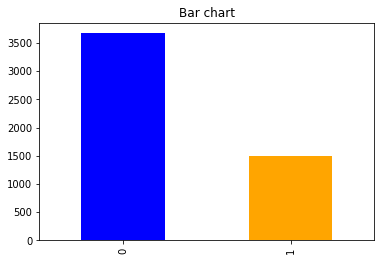

In [ ]:
#Bar plot of class labels
plt.rcParams['figure.figsize'] = (6, 4)
count_Class=pd.value_counts(dataset_mails_clean["label_num"], sort= True)
count_Class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

##Visualization of text length in spam and non-spam

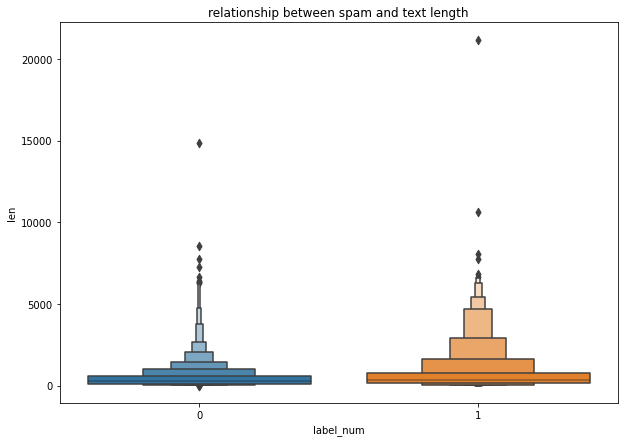

In [ ]:
# It is similar to a box plot in plotting a nonparametric representation 
#of a distribution in which all features correspond to actual observations. 
#By plotting more quantiles, it provides more information about the shape 
#of the distribution, particularly in the tails.
plt.rcParams['figure.figsize'] = (10, 7)
sns.boxenplot(x = dataset_mails_clean['label_num'], y = dataset_mails_clean['len'])
plt.title('relationship between spam and text length')
plt.show()

##Word frequency

In [ ]:
count1 = Counter(" ".join(dataset_mails_clean[dataset_mails_clean['label_num']==0]["text_clean"]).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})
count2 = Counter(" ".join(dataset_mails_clean[dataset_mails_clean['label_num']==1]["text_clean"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})

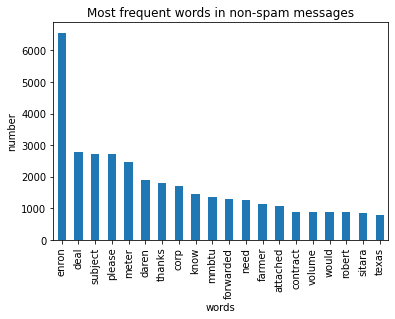

In [ ]:
plt.rcParams['figure.figsize'] = (6, 4)
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('Most frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

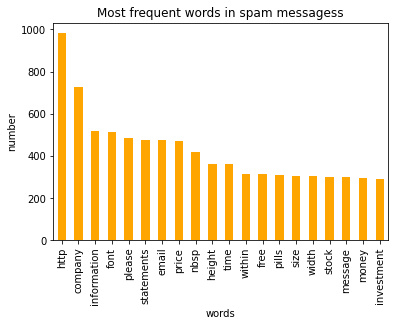

In [ ]:
plt.rcParams['figure.figsize'] = (6, 4)
df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('Most frequent words in spam messagess')
plt.xlabel('words')
plt.ylabel('number')
plt.show()


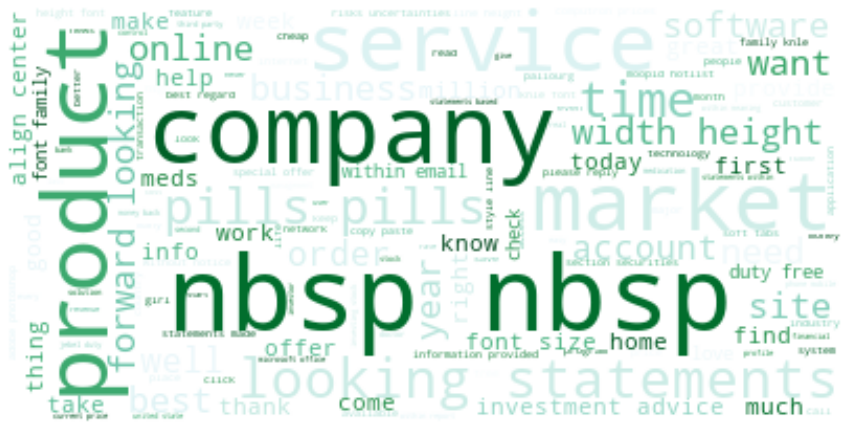

In [ ]:
from wordcloud import WordCloud
# text = ' '.join(dataset_mails_clean.text_clean.values)
text = ' '.join(dataset_mails_clean[dataset_mails_clean['label_num']==1].text_clean.values)

wordcloud = WordCloud(max_font_size=50, max_words=1000, background_color="white",  colormap='BuGn').generate(text.lower())
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#Train Test Data

In [ ]:
x = dataset_mails_clean['text_clean']
y = dataset_mails_clean['label_num']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2)

In [ ]:
print(x_train.shape, x_test.shape)

(4136,) (1035,)


In [ ]:
print("Samples per class in train {}".format(np.bincount(y_train)))
print("Samples per class in test {}".format(np.bincount(y_test)))

Samples per class in train [2949 1187]
Samples per class in test [723 312]


#Feature Extraction: Bag of words

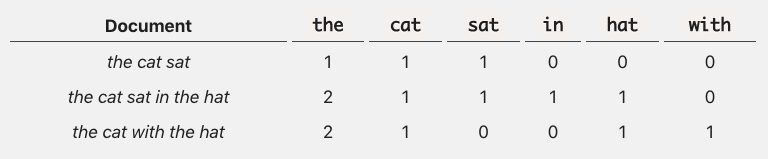

In [ ]:
bow_vec = CountVectorizer()

In [ ]:
train_bow = bow_vec.fit_transform(x_train)
test_bow = bow_vec.transform(x_test) #Why only transform?

In [ ]:
cv_df = pd.DataFrame(train_bow.toarray(),columns = bow_vec.get_feature_names_out())
cv_df.head()

,aaas,aabda,aabvmmq,aafco,aaiabe,aaigrcrb,aalland,aambique,aaoeuro,aare,aarhus,aaron,aashqcsny,aavilable,aaxrzm,ababa,abacha,aback,abackof,abacus,abacustech,abandone,abandoned,abarch,abasements,abash,abate,abater,abazis,abbas,abbasi,abbe,abbey,abbot,abbott,abbpge,abby,abcdef,abcdzhongguo,abdominal,...,ztufjzkn,ztuje,ztvi,zufferli,zugpju,zuidholland,zukin,zunnw,zurich,zusagen,zusammenhang,zustande,zuybzbq,zvikydqu,zvjc,zvrkxjmex,zwallet,zwftnqlp,zwiers,zwmdjvr,zxaghur,zxgwvpiadobe,zxgwvpihere,zxgwvpiimg,zxgwvpimacromedia,zxgwvpimicrosoft,zxgwvpinorton,zxzmcnbf,zyban,zyjvit,zykfe,zynsdirnh,zynve,zyqtaqlt,zyrtec,zyyqywp,zzezrjok,zzocb,zzso,zzsyt
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
feature_names = bow_vec.get_feature_names_out()
print("Number of features: {}".format(len(feature_names)))

Number of features: 37238


- Try: TF-IDF Feature 
  - tfidf = TfidfVectorizer()



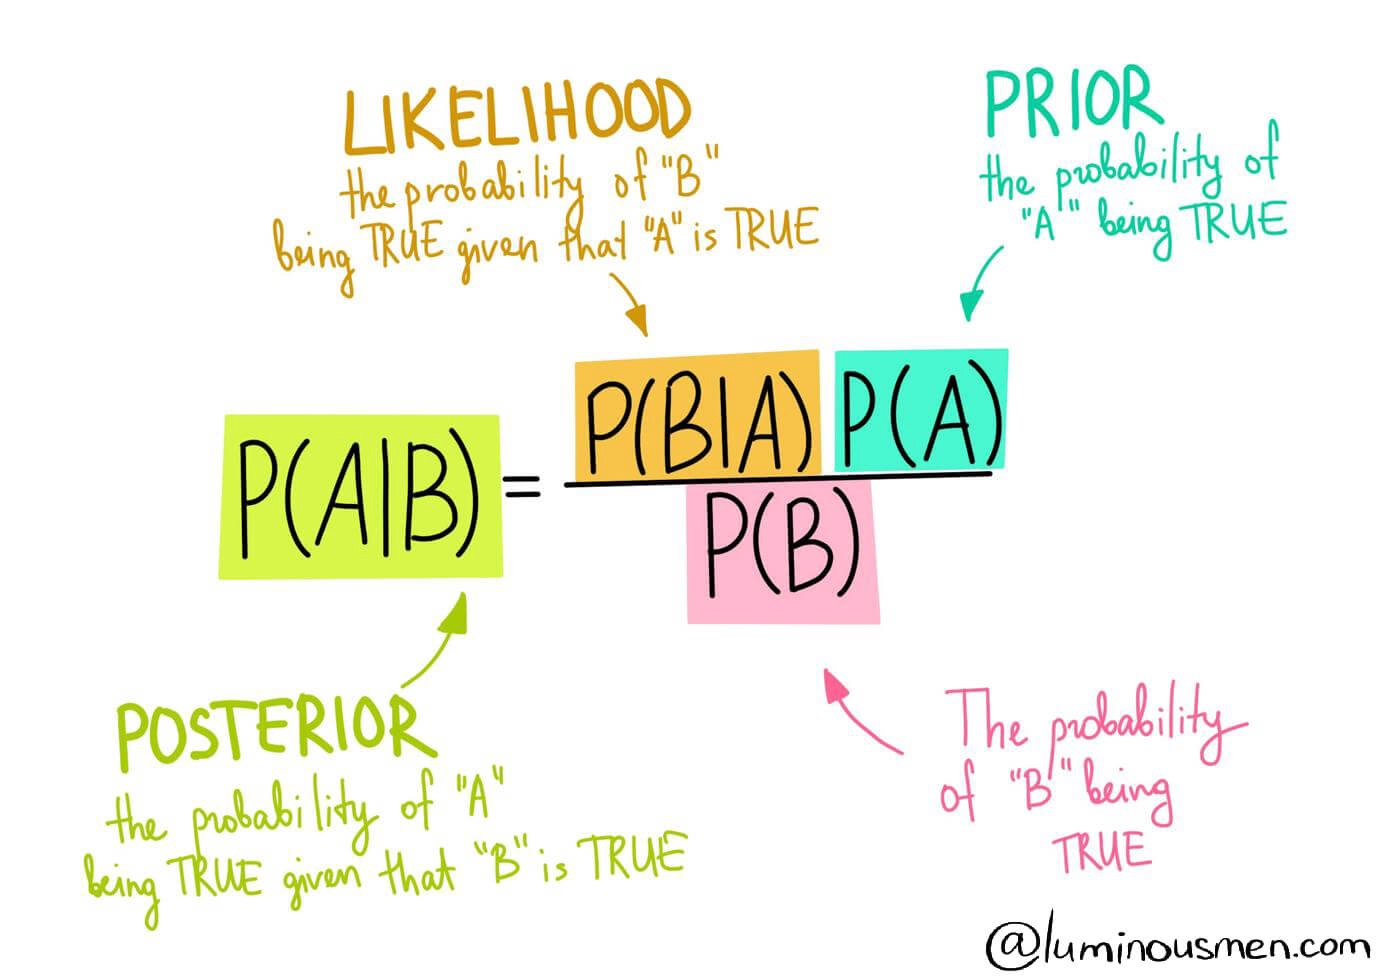

In [ ]:
# clf = MultinomialNB()#SVC()
# clf.fit(X_train, y_train)
# y_pred=clf.predict(X_test)
# accuracy_score (y_test,y_pred )

In [ ]:
## Preparing to make a pipeline 
models = {
    'Naive Bayes': MultinomialNB(),
    'Bernoulli Naive Bayes': BernoulliNB(),
    'Perceptron': MLPClassifier()
}

params = {
    'Naive Bayes': { 'alpha': [0.5, 1], 'fit_prior': [True, False] },
    'Bernoulli Naive Bayes': { 'alpha': [0.5, 1], 'fit_prior': [True, False] },
    'Perceptron': { 'activation': ['tanh', 'relu'] }
}

In [ ]:
# Use multiple classifiers and grid search for prediction
def ML_modeling(models, params, X_train, X_test, y_train, y_test, performance_metrics):    
    
    if not set(models.keys()).issubset(set(params.keys())):
        raise ValueError('Some estimators are missing parameters')

    for key in models.keys():
    
        model = models[key]
        param = params[key]

        gs = GridSearchCV(model, param, cv=10, error_score=0, refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        
        # Print scores for the classifier
        accuracy_sc = accuracy_score(y_test, y_pred)
        precision_sc= precision_score(y_test, y_pred, average='macro')
        recall_sc = recall_score(y_test, y_pred, average='macro')
        f1_sc =  f1_score(y_test, y_pred, average='macro')
        
        performance_metrics.append([key,accuracy_sc,precision_sc,recall_sc,f1_sc])
        print(key, ':', gs.best_params_)
        print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \t\tF1: %1.3f\n" % (accuracy_sc, precision_sc, recall_sc, f1_sc))

        sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,  fmt='g')
        plt.show()
        
    return 

==============Bag of Words==============

Naive Bayes : {'alpha': 0.5, 'fit_prior': False}
Accuracy: 0.974 	Precision: 0.974 	Recall: 0.964 		F1: 0.969



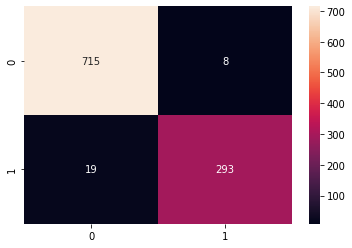

Bernoulli Naive Bayes : {'alpha': 0.5, 'fit_prior': False}
Accuracy: 0.846 	Precision: 0.876 	Recall: 0.758 		F1: 0.788



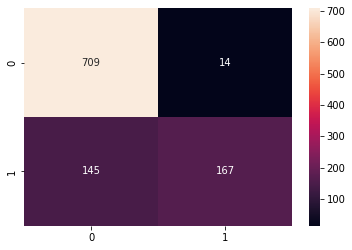

Perceptron : {'activation': 'tanh'}
Accuracy: 0.982 	Precision: 0.979 	Recall: 0.978 		F1: 0.978



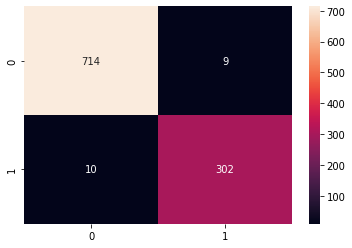

In [ ]:
performance_metrics_bow = []
print("==============Bag of Words==============\n")
ML_modeling(models, params, train_bow, test_bow, y_train, y_test, performance_metrics_bow)
metrics_bow_df = pd.DataFrame(performance_metrics_bow,columns=['Model' , 'Accuracy', 'Precision' , 'Recall', "F1 Score"])

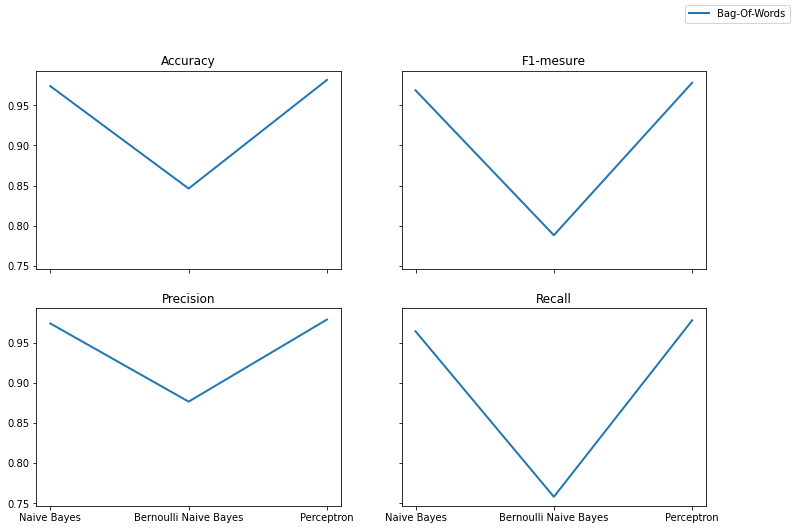

In [ ]:
f, axes = plt.subplots(2, 2, figsize=(12,8), sharey = True, sharex = True)

axes[0, 0].plot(metrics_bow_df['Model'], metrics_bow_df['Accuracy'], linestyle = 'solid', linewidth = 2, label = 'Bag-Of-Words')
axes[0, 0].set_title('Accuracy')

axes[0, 1].plot(metrics_bow_df['Model'], metrics_bow_df['F1 Score'], linestyle = 'solid', linewidth = 2)
axes[0, 1].set_title('F1-mesure')

axes[1, 0].plot(metrics_bow_df['Model'], metrics_bow_df['Precision'], linestyle = 'solid', linewidth = 2)
axes[1, 0].set_title('Precision')

axes[1, 1].plot(metrics_bow_df['Model'], metrics_bow_df['Recall'], linestyle = 'solid', linewidth = 2)
axes[1, 1].set_title('Recall')

f.legend()
f.show()

#Othe features

In [ ]:
from gensim.models import Word2Vec
from tqdm import tqdm
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
words_in_sentences=[]
for i in tqdm(x_train):
    words_in_sentences.append(i.split())

100%|██████████| 4136/4136 [00:00<00:00, 32884.28it/s]


In [ ]:
wv_model = Word2Vec(sentences=words_in_sentences,workers=-1)

In [ ]:
wv_model.wv.most_similar('lottery', topn=10)

[('mmbtus', 0.39898014068603516),
 ('trailer', 0.3825925290584564),
 ('rico', 0.3682039976119995),
 ('friend', 0.3653508722782135),
 ('santa', 0.3511229157447815),
 ('removal', 0.3478802442550659),
 ('generated', 0.33671465516090393),
 ('equal', 0.3307230770587921),
 ('mcfd', 0.3275928795337677),
 ('cousino', 0.3237266540527344)]

In [ ]:
print(len(wv_model.wv.get_vector('company')))
print(wv_model.wv.get_vector('company'))

100
[ 2.8066940e-03  1.1089418e-05 -4.1563590e-03 -3.1197050e-03
 -6.8544032e-04 -5.0650386e-04 -2.0330902e-03 -4.7606616e-03
  2.9707202e-03  4.3348810e-03  1.4576141e-03 -4.2465543e-03
  2.1526415e-03 -2.9894633e-03  4.0908675e-03 -2.1264141e-03
  3.0187452e-03  4.3515661e-03 -3.4042375e-04  5.5107434e-04
  3.3222702e-03 -2.9353655e-03  2.3798342e-03  3.9191692e-04
 -5.5000797e-04  2.2362615e-03  3.9122785e-03  1.8310891e-03
  2.4647126e-03 -6.1061047e-04 -5.2535695e-05 -7.8517140e-04
  1.1673633e-03  1.6734075e-03 -3.4782316e-03  9.7289681e-04
  3.4166367e-03  1.9641966e-03 -4.1628410e-03  3.0344303e-04
 -4.2232499e-03  1.2533785e-03  4.4141798e-03  1.2164683e-03
  1.7081163e-03 -4.0181917e-03 -4.0627387e-03  4.0656226e-03
  1.3404834e-03 -1.3910353e-03  7.6628232e-04  2.5032116e-03
  1.1256364e-03 -3.2968833e-03  4.4686443e-04 -2.9067453e-03
 -2.1650174e-03  4.2849504e-03  4.2407471e-03  1.9749543e-03
  1.8733750e-04 -2.7760670e-03  2.2279944e-03  3.1411272e-04
  3.3266828e-03  3.0

In [ ]:
vocab=list(wv_model.wv.vocab.keys())
print(len(vocab))

6913


In [ ]:
def avg_w2vec(sentences):
    transformed=[]
    for sentence in tqdm(sentences):
        count=0
        vector=np.zeros(100)
        for word in sentence.split():
            if word in vocab:
                vector+=wv_model.wv.get_vector(word)
                count+=1
        if count!=0:
            vector/=count
            transformed.append(vector)
        else:
            # print(sentence)
            transformed.append(np.random.rand(100))
    
    return np.array(transformed)

In [ ]:
x_train_transformed=avg_w2vec(x_train)
x_test_transformed=avg_w2vec(x_test)

100%|██████████| 1035/1035 [00:05<00:00, 206.57it/s]


In [ ]:
## Preparing to make a pipeline 
models = {
    # 'Naive Bayes': MultinomialNB(),
    # 'Bernoulli Naive Bayes': BernoulliNB(),
    'Perceptron': MLPClassifier()
}

params = {
    # 'Naive Bayes': { 'alpha': [0.5, 1], 'fit_prior': [True, False] },
    # 'Bernoulli Naive Bayes': { 'alpha': [0.5, 1], 'fit_prior': [True, False] },
    'Perceptron': { 'activation': ['tanh', 'relu'] }
}

- Can we use Naive Bayes?

============== Word2vec ==============

Perceptron : {'activation': 'tanh'}
Accuracy: 0.866 	Precision: 0.860 	Recall: 0.811 		F1: 0.830



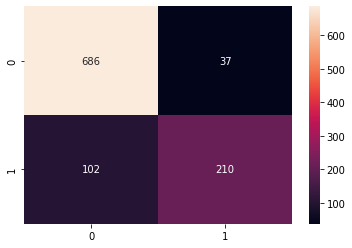

In [ ]:
performance_metrics_wv = []
print("============== Word2vec ==============\n")
ML_modeling(models, params, x_train_transformed, x_test_transformed, y_train, y_test, performance_metrics_wv)
metrics_bow_df = pd.DataFrame(performance_metrics_wv,columns=['Model' , 'Accuracy', 'Precision' , 'Recall', "F1 Score"])